<a href="https://colab.research.google.com/github/salminadia/Python-Machine-Learning/blob/master/xgboost_tuning%2Blgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Loaded data from kaggle API**



In [ ]:

# Colab library to upload files to notebook
from google.colab import files
#Install Kaggle library
!pip install -q kaggle

In [ ]:
#Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "nadiasalmi" # username from the json file
os.environ['KAGGLE_KEY'] = "111559c83d6fb4454e6c3764f5976b64" # key from the json file
!kaggle competitions download -c microsoft-malware-prediction # api copied from kaggle

 97% 649M/672M [00:07<00:00, 87.4MB/s]
100% 672M/672M [00:07<00:00, 95.4MB/s]
 84% 113M/134M [00:01<00:00, 67.4MB/s] 
100% 134M/134M [00:01<00:00, 77.4MB/s]
 97% 745M/768M [00:10<00:00, 41.1MB/s]
100% 768M/768M [00:10<00:00, 74.5MB/s]


In [2]:
!unzip sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


# Feature engineering 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
# en raison des limitations de la mémoire de  et de l'énorme taille du jeu de données, un échantillon de l'ensemble
train_sample_fraction = 0.2

# Valeurs NA qui dépassent ce taux
na_rate_threshold = 0.9

#seuil pour supprimer les colonnes avec des caractéristiques déséquilibrées à leurs valeurs 
unbalanced_feature_rate_threshold = 0.9


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#l'idée principale de charger le jeu de données et d'économiser de l'espace mémoire !!
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

*Base d'entrainement*

---



In [5]:
%%time
train = pd.read_csv('train.csv', dtype=dtypes)

CPU times: user 2min 35s, sys: 7.3 s, total: 2min 42s
Wall time: 2min 46s


In [6]:
good_cols = list(train.columns)

for col in train.columns:
    
# supprimer les colonnes avec un taux NA élevé
    na_rate = train[col].isnull().sum() / train.shape[0]
    
    # supprimer les colonnes avec un taux élevé de valeurs asymétriques
    unbalanced_rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    
    if na_rate > na_rate_threshold:
        good_cols.remove(col)
    elif unbalanced_rate > unbalanced_feature_rate_threshold:
        good_cols.remove(col)

In [7]:
good_cols

['MachineIdentifier',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryType',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion

In [8]:
train = train[good_cols]

In [9]:
import gc

gc.collect()

0

In [10]:
train.shape

(8921483, 57)

In [11]:
categorical_columns = list(train.loc[:, train.dtypes =="category"].columns)
numerical_and_binary_columns = list(train.loc[:, train.dtypes !="category"].columns)
numerical_columns = numerical_and_binary_columns

categorical_columns.remove("MachineIdentifier")

binary_columns = []
for col in (numerical_and_binary_columns):
    if train[col].nunique() == 2:
        binary_columns.append(col)
        numerical_columns.remove(col)

In [12]:
import gc
train_sample = train.sample(frac=train_sample_fraction, random_state=42)



In [13]:
train_sample.shape

(1784297, 57)

**Base de test**

---



In [14]:
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}

# get all columns except
test = pd.read_csv('test.csv', dtype=test_dtypes, usecols=good_cols[:-1])

#test = reduce_mem_usage(test)

In [15]:
train_ids = train_sample['MachineIdentifier']
test_ids = test['MachineIdentifier']

In [16]:
#supprission des targets pour faciliter l'encoding
train_sample = train_sample.drop(['MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)

In [17]:
train_sample = train_sample.reset_index(drop=True)

In [18]:
#Remplir les valeurs NA avec le mode statistique
modes = train_sample.mode()

for col in train_sample.columns:
    train_sample[col] = np.where(train_sample[col].isnull(), modes[col], train_sample[col])

del modes

In [19]:
#Remplir les valeurs NA avec le mode statistique
modes_test = test.mode()

for col in test.columns:
    test[col] = np.where(test[col].isnull(), modes_test[col], test[col])

#train_sample.shape
del modes_test

In [20]:
#Encoder les fonctionnalités catégorielles (train)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def MultiLabelEncoder(columnlist,dataframe):
    for i in columnlist:
        #print(i)
        labelencoder_X=LabelEncoder()
        dataframe[i]=labelencoder_X.fit_transform(dataframe[i])

MultiLabelEncoder(categorical_columns, train_sample)

In [21]:
#Encoder les fonctionnalités catégorielles(test)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def MultiLabelEncoder(columnlist,dataframe):
    for i in columnlist:
        #print(i)
        labelencoder_X=LabelEncoder()
        dataframe[i]=labelencoder_X.fit_transform(dataframe[i])

MultiLabelEncoder(categorical_columns, test)

In [22]:
train_cols = [c for c in train_sample.columns if c not in ["HasDetections"]]
y_train = train_sample["HasDetections"]

In [23]:
y_train.value_counts()

0    893061
1    891236
Name: HasDetections, dtype: int64

In [24]:
y = train_sample['HasDetections']
X = train_sample.drop(['HasDetections'], axis=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Importation des librairies**

---



In [25]:
import numpy as np 
import pandas as pd 
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score,  precision_score, recall_score, confusion_matrix,accuracy_score
import xgboost as xgb

In [ ]:
! pip install scikit-plot

# algorithme xgboost baseline

In [26]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

In [ ]:
params = {'tree_method': 'hist',
          #régression logistique pour la classification binaire, probabilité de sortie
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.0936165921314771,
 'max_depth': 2,
 'colsample_bytree': 0.3561271102144279,
 'subsample': 0.8246604621518232,
 'min_child_weight': 53,
 'gamma': 9.943467991283027,
 'silent': 1}            
                        

In [ ]:
%%time

oof_preds = np.zeros(train_sample.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_sample, y_train)):
    
    trn_x, trn_y = train_sample[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train_sample[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('Cross validation Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('Cross validation Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('Cross validation F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))


[0]	Train-auc:0.58549	Val-auc:0.584267
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.685454	Val-auc:0.683122
[200]	Train-auc:0.691776	Val-auc:0.689482
[300]	Train-auc:0.695275	Val-auc:0.693034
[400]	Train-auc:0.697553	Val-auc:0.695322
[500]	Train-auc:0.699634	Val-auc:0.697447
[600]	Train-auc:0.701072	Val-auc:0.698842
[700]	Train-auc:0.702374	Val-auc:0.700149
[800]	Train-auc:0.703658	Val-auc:0.701427
[900]	Train-auc:0.704832	Val-auc:0.702628
[1000]	Train-auc:0.705654	Val-auc:0.703427
[1100]	Train-auc:0.706473	Val-auc:0.704174
[1200]	Train-auc:0.707076	Val-auc:0.704794
[1300]	Train-auc:0.707728	Val-auc:0.705425
[1400]	Train-auc:0.708234	Val-auc:0.705931
[1500]	Train-auc:0.708629	Val-auc:0.706298
[1600]	Train-auc:0.709048	Val-auc:0.706701
[1700]	Train-auc:0.709484	Val-auc:0.707104
[1800]	Train-auc:0.709851	Val-auc:0.707487
[1900]	Train-auc:0.710127	Val-auc:0.707731
[2000]	Train-a

[[583865 309196]
 [313453 577783]]


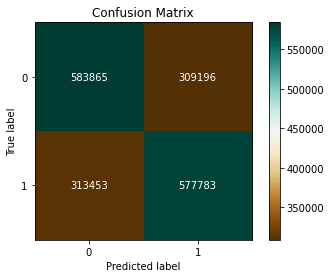

In [ ]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
print(confusion_matrix(y_train, np.round(oof_preds)))
skplt.metrics.plot_confusion_matrix(y_train, np.round(oof_preds), cmap="BrBG")

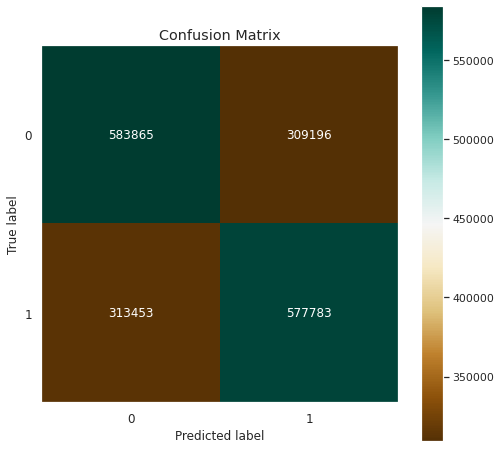

In [ ]:

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(y_train, np.round(oof_preds), cmap="BrBG")

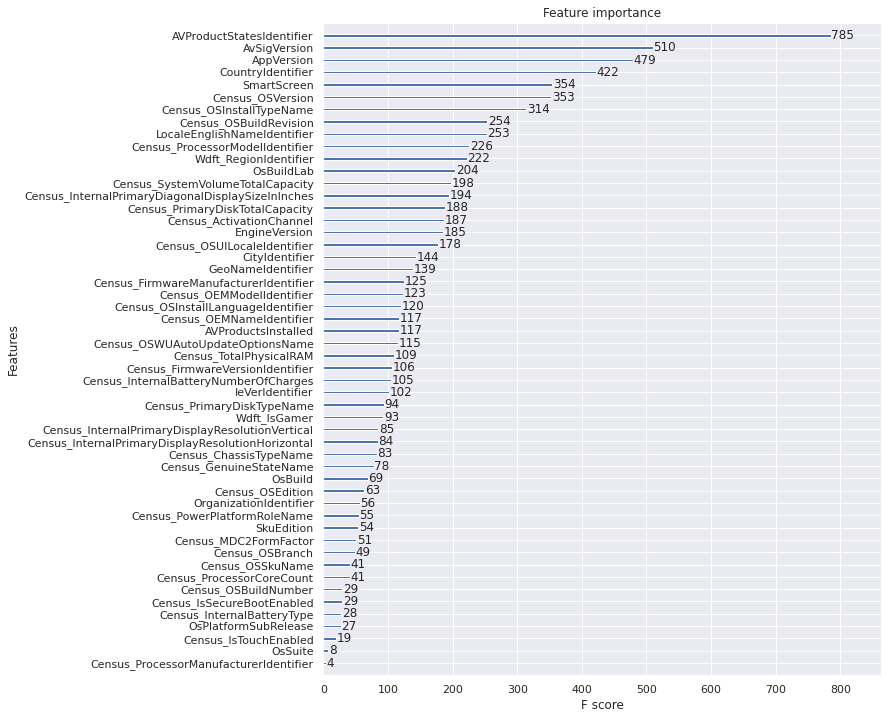

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,12)) 
xgb.plot_importance(clf, max_num_features=57, ax=ax)  

In [ ]:

oof_roc = roc_auc_score(y_train, oof_preds)


In [ ]:
print(oof_roc )

0.7122472107766223


## ***LGBM Model*** 
 lgb.train()

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics


In [26]:
param = {
    'objective' :'binary', 
                                   'class_weight' : 'balanced', 'learning_rate' :0.09, 
                                   'reg_alpha' : 0.1, 'reg_lambda' : 0.1, 
                                   'subsample' :0.8, 'n_jobs ':-1, 'random_state' : 50,
        'max_depth': 53

    }
   

In [27]:
features = [c for c in train_sample.columns if c not in ['MachineIdentifier', 'HasDetections']]
target = train_sample['HasDetections']

In [31]:
%%time
from sklearn.metrics import roc_auc_score, roc_curve
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train_sample))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

start = time.time()


for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_sample.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_sample.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_sample.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 4000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 50)
    oof[val_idx] = clf.predict(train_sample.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold n°0
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.61637	valid_1's binary_logloss: 0.618201
[200]	training's binary_logloss: 0.610841	valid_1's binary_logloss: 0.613815
[300]	training's binary_logloss: 0.607711	valid_1's binary_logloss: 0.611933
[400]	training's binary_logloss: 0.605207	valid_1's binary_logloss: 0.610755
[500]	training's binary_logloss: 0.603052	valid_1's binary_logloss: 0.609928
[600]	training's binary_logloss: 0.601144	valid_1's binary_logloss: 0.609316
[700]	training's binary_logloss: 0.599382	valid_1's binary_logloss: 0.608875
[800]	training's binary_logloss: 0.597678	valid_1's binary_logloss: 0.608491
[900]	training's binary_logloss: 0.596049	valid_1's binary_logloss: 0.608179
[1000]	training's binary_logloss: 0.59435	valid_1's binary_logloss: 0.607784
[1100]	training's binary_logloss: 0.592944	valid_1's binary_logloss: 0.607632
[1200]	training's binary_logloss: 0.591372	valid_1's binary_logloss: 0.607329
[130

In [ ]:
train.shape

(8921483, 57)

In [ ]:
test.shape

(7853253, 55)

# **2end model lgbm**
lgb.LGBMClassifier +fit()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(train_sample, test, encoding = 'ohe', n_folds = 5):
    
    """Former et tester un modèle GBM en utilisant la
     validation croisée.
    
    Paramètres
    --------
        features (pd.DataFrame): 
            cadre de données des fonctionnalités de formation à utiliser
             pour la formation d'un modèle. Doit inclure la colonne CIBLE.
        test_features (pd.DataFrame): 
            dataframe des fonctionnalités de test à utiliser
             pour faire des prédictions avec le modèle.
        encoding (str, default = 'ohe'): 
            méthode d'encodage de variables catégorielles. Soit 'ohe' pour un codage one-hot ou 'le' pour un codage d'étiquette
             n_folds (int, default = 5): nombre de plis à utiliser pour la validation croisée
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe avec `MachineIdentifier` et `HasDetections` probabilities
            prédites par le modèle.
        feature_importances (pd.DataFrame): 
            dataframe avec les fonctionnalités importantes du model.
        valid_metrics (pd.DataFrame): 
            dataframe de formation et validation avec la metric (ROC AUC) pour chaque pli et dans son ensemble..
        
 
    """
   
    # Extraction de la colonne de la cible
    labels = train_sample['HasDetections']
    train = train_sample.drop(columns = ['HasDetections'])
    

   # One Hot Encoding
    if encoding == 'ohe':
        
        # Alignement des dataframes
        train_sample, test = train_sample.align(test, join = 'inner', axis = 1)
        # Aucun index catégorique à enregistrer
        cat_indices = 'auto'
    
     # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Itération dans chaque colonne
        for i, col in enumerate(train_sample):
            if train_sample[col].dtype == 'object':
                train_sample[col] = label_encoder.fit_transform(np.array(train_sample[col].astype(str)).reshape((-1,)))
                test[col] = label_encoder.transform(np.array(test[col].astype(str)).reshape((-1,)))
                cat_indices.append(i)
    
    # Affichage d'une erreur
    else:
        raise ValueError("Encodage doit etre soit 'ohe' ou 'le'")
        
    print("LGBM Model ")
   
    # Extraction des noms des fonctionnalités
    feature_names     = list(train_sample.columns)
   
   
    
    # Créer un tableau avec np.array
    train_sample= np.array(train_sample)
    test = np.array(test)
    
    # Creation de kfold object
    # n_folds : nombre de segment
    # shuffle : si on mélange les données avant la décomposition
    # random_state : la graine de générateur de nombre aléatoire
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Tableau vide à remplir avec les fonctionnalités importantes 
    feature_importance_values = np.zeros(len(feature_names))
    
    # Tableau vide à remplir avec les probabilités prédites
    test_predictions = np.zeros(test.shape[0])
    
    # Tableau vide pour les prédictions de validation hors du fold(pli)
    out_of_fold = np.zeros(train_sample.shape[0])
    
    # Listes d'enregistrement de valid_scores et train_scores
    valid_scores = []
    train_scores = []
    
    # Itérer à travers chaque segment (fold)
    for train_indices, valid_indices in k_fold.split(train):
        
        # Données d'entraînement pour le segment (fold)
        train_features, train_labels = train_sample[train_indices], labels[train_indices]
        # Données de validation pour le segment (fold)
        valid_features, valid_labels = train_sample[valid_indices], labels[valid_indices]
        
        #train_features, train_labels = X.iloc[train_index, :], X.iloc[test_index, :]
        #valid_features, valid_labels = y[train_index], y[test_index]
        # Création du modèle
        # n_estimators = nbr d'arbres, objective = binaire
        # alpha, lamda = coefficient de pinalité, pour ne pas réduire la fonction coût rapidement
        # class_weight : poids de classe = équilibré
        # learning_rate = taux d'apprentissage
        # random_stat : pour fixer la suite aléatoire produite
        # subsample : sous échantiant
        # n_jobs = -1 tous les coeurs du processeur sont activés
        model = lgb.LGBMClassifier(n_estimators=4000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.09, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Tourner le model sur les données train, la metrique utilisée est AUC ROC
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 50, verbose = 200)
        
        # Meilleures iteration
        best_iteration = model.best_iteration_
        
        # Importances des variables 
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # predictions
        test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Enregistrer les prédictions du fold
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Enregistrer le meilleur score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Nettoyer la mémoire
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
       
    # Faire la dataframe de soumission
    submission = pd.DataFrame({'MachineIdentifier': test_ids, 'HasDetections': test_predictions})
    
    # dataframe des fonctionnalités importantes
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Score de validation global
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Ajouter les scores globaux aux métriques
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Nécessaire pour créer une base de données de scores de validation
    fold_names = list(range(n_folds))
    fold_names.append('Score global')
    
    # Dataframe des scores de validation
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                   
                            'valid': valid_scores
                            }) 
    
    return submission,feature_importances, metrics
print('done')    

done


In [ ]:
  %%time
submission, fi, metrics = model(train_sample, test)
print('Baseline metrics')
print(metrics)


LGBM Model 
Training until validation scores don't improve for 50 rounds.
[200]	train's auc: 0.719938	train's binary_logloss: 0.611195	valid's auc: 0.717233	valid's binary_logloss: 0.612592
[400]	train's auc: 0.727735	train's binary_logloss: 0.605511	valid's auc: 0.721241	valid's binary_logloss: 0.609496
[600]	train's auc: 0.733234	train's binary_logloss: 0.60152	valid's auc: 0.722984	valid's binary_logloss: 0.608136
[800]	train's auc: 0.738098	train's binary_logloss: 0.597972	valid's auc: 0.724172	valid's binary_logloss: 0.607192
[1000]	train's auc: 0.742404	train's binary_logloss: 0.594826	valid's auc: 0.724873	valid's binary_logloss: 0.606622
[1200]	train's auc: 0.74657	train's binary_logloss: 0.591717	valid's auc: 0.72552	valid's binary_logloss: 0.606094
[1400]	train's auc: 0.750362	train's binary_logloss: 0.58888	valid's auc: 0.725954	valid's binary_logloss: 0.605746
[1600]	train's auc: 0.754036	train's binary_logloss: 0.586121	valid's auc: 0.72632	valid's binary_logloss: 0.605433

#telechrg .html le notebook

In [ ]:
import os

In [ ]:
os.environ['COLAB_TPU_ADDR']

'10.14.77.90:8470'

In [ ]:
!jupyter nbconvert --to html nadia.ipynb

# XGBOOST WITH TUNING 

In [ ]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search

gc.collect()

param_test1 = {
   'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=35, gamma=9.943467991283027, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test1, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)

gsearch1.fit(trn_x , trn_y)
gsearch1.best_params_, gsearch1.best_score_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ..... max_depth=3, min_child_weight=1, score=0.682, total=   5.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ..... max_depth=3, min_child_weight=1, score=0.683, total=   5.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ..... max_depth=3, min_child_weight=1, score=0.684, total=   5.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.2s remaining:    0.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ..... max_depth=3, min_child_weight=3, score=0.682, total=   5.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

({'max_depth': 9, 'min_child_weight': 5}, 0.7087917864047807)

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=35, gamma=9.943467991283027, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)

gsearch2.fit(trn_x , trn_y)
gsearch2.best_params_, gsearch2.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=4, min_child_weight=4 .................................
[CV] ..... max_depth=4, min_child_weight=4, score=0.689, total=   8.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] ..... max_depth=4, min_child_weight=4, score=0.691, total=   7.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.6s remaining:    0.0s
[CV] max_depth=4, min_child_weight=4 .................................
[CV] ..... max_depth=4, min_child_weight=4, score=0.691, total=   7.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] ..... max_depth=4, min_child_weight=5, score=0.689, total=   7.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

({'max_depth': 6, 'min_child_weight': 6}, 0.7087917864047807)

In [ ]:
param_test2b = {
'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=35, gamma=9.943467991283027, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test2b, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)

gsearch2b.fit(trn_x , trn_y)
gsearch2b.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] min_child_weight=6 ..............................................
[CV] .................. min_child_weight=6, score=0.675, total=   5.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[CV] min_child_weight=6 ..............................................
[CV] .................. min_child_weight=6, score=0.677, total=   5.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[CV] min_child_weight=6 ..............................................
[CV] .................. min_child_weight=6, score=0.675, total=   4.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.1s remaining:    0.0s
[CV] min_child_weight=8 ..............................................
[CV] .................. min_child_weight=8, score=0.675, total=   5.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

({'min_child_weight': 6}, 0.7087917864047807)

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=35, gamma=9.943467991283027, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test3, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)

gsearch3.fit(trn_x , trn_y)
gsearch3.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gamma=0.0 .......................................................
[CV] ........................... gamma=0.0, score=0.675, total=   5.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[CV] gamma=0.0 .......................................................
[CV] ........................... gamma=0.0, score=0.677, total=   5.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[CV] gamma=0.0 .......................................................
[CV] ........................... gamma=0.0, score=0.675, total=   4.7s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s
[CV] gamma=0.1 .......................................................
[CV] ........................... gamma=0.1, score=0.675, total=   4.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

({'gamma': 0.0}, 0.7087917864047807)

In [ ]:
from sklearn.model_selection import GridSearchCV   #Perforing grid search
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=140, gamma=0, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test4, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)
gsearch4.fit(trn_x , trn_y)
gsearch4.best_params_, gsearch4.best_score_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] . colsample_bytree=0.6, subsample=0.6, score=0.687, total=  15.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] . colsample_bytree=0.6, subsample=0.6, score=0.689, total=  15.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.1s remaining:    0.0s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] . colsample_bytree=0.6, subsample=0.6, score=0.688, total=  15.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.6s remaining:    0.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] . colsample_bytree=0.6, subsample=0.7, score=0.687, total=  15.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapse

({'colsample_bytree': 0.9, 'subsample': 0.6}, 0.6886697208238418)

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=140, gamma=0, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test5, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)
gsearch5.fit(trn_x , trn_y)
gsearch5.best_params_, gsearch5.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] colsample_bytree=0.75, subsample=0.75 ...........................
[CV]  colsample_bytree=0.75, subsample=0.75, score=0.687, total=  15.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s
[CV] colsample_bytree=0.75, subsample=0.75 ...........................
[CV]  colsample_bytree=0.75, subsample=0.75, score=0.689, total=  15.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.5s remaining:    0.0s
[CV] colsample_bytree=0.75, subsample=0.75 ...........................
[CV]  colsample_bytree=0.75, subsample=0.75, score=0.688, total=  15.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.7s remaining:    0.0s
[CV] colsample_bytree=0.75, subsample=0.8 ............................
[CV]  colsample_bytree=0.75, subsample=0.8, score=0.687, total=  15.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

({'colsample_bytree': 0.85, 'subsample': 0.8}, 0.688397534070643)

In [ ]:
params = {'tree_method': 'hist',
          #régression logistique pour la classification binaire, probabilité de sortie
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.09,
 'max_depth': 6,
 'colsample_bytree': 0.85,
 'subsample': 0.8,
 'min_child_weight': 4,
 'gamma': 0,
 'silent': 1}

In [ ]:
%%time

oof_preds = np.zeros(train_sample.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_sample, y_train)):
    
    trn_x, trn_y = train_sample[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train_sample[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('CV Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('CV Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('CV F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))

[0]	Train-auc:0.673604	Val-auc:0.670803
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.712633	Val-auc:0.708207
[200]	Train-auc:0.722187	Val-auc:0.715448
[300]	Train-auc:0.728045	Val-auc:0.718894
[400]	Train-auc:0.732571	Val-auc:0.721047
[500]	Train-auc:0.73652	Val-auc:0.722663
[600]	Train-auc:0.739978	Val-auc:0.723737
[700]	Train-auc:0.742999	Val-auc:0.724448
[800]	Train-auc:0.745969	Val-auc:0.725073
[900]	Train-auc:0.748654	Val-auc:0.725557
[1000]	Train-auc:0.751129	Val-auc:0.725828
[1100]	Train-auc:0.753487	Val-auc:0.726077
[1200]	Train-auc:0.755899	Val-auc:0.726382
[1300]	Train-auc:0.758116	Val-auc:0.72653
[1400]	Train-auc:0.760193	Val-auc:0.726695
[1500]	Train-auc:0.762372	Val-auc:0.726896
[1600]	Train-auc:0.764488	Val-auc:0.726992
[1700]	Train-auc:0.766451	Val-auc:0.727094
Stopping. Best iteration:
[1699]	Train-auc:0.766434	Val-auc:0.727096


Fold 1 AUC 0.727074 & std 0.19

In [ ]:
params = {'tree_method': 'hist',
          #régression logistique pour la classification binaire, probabilité de sortie
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.09,
 'max_depth': 10,
 'colsample_bytree': 0.85,
 'subsample': 0.8,
 'min_child_weight': 4,
 'gamma': 9,
 'silent': 1}



In [ ]:
%%time

oof_preds = np.zeros(train_sample.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_sample, y_train)):
    
    trn_x, trn_y = train_sample[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train_sample[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('CV Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('CV Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('CV F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))

[0]	Train-auc:0.690441	Val-auc:0.685406
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.736345	Val-auc:0.721015
[200]	Train-auc:0.747385	Val-auc:0.725366
[300]	Train-auc:0.754022	Val-auc:0.726833
[400]	Train-auc:0.759142	Val-auc:0.727569
[500]	Train-auc:0.763483	Val-auc:0.728008
[600]	Train-auc:0.767154	Val-auc:0.728309
[700]	Train-auc:0.770327	Val-auc:0.728432
[800]	Train-auc:0.77322	Val-auc:0.728577
[900]	Train-auc:0.775906	Val-auc:0.728663
Stopping. Best iteration:
[898]	Train-auc:0.775877	Val-auc:0.728676


Fold 1 AUC 0.728653 & std 0.201058
Fold 1 Precision 0.665563
Fold 1 Recall 0.656636
Fold 1 F1 score 0.661069
[0]	Train-auc:0.689875	Val-auc:0.688375
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.736474	Val-auc:0.721853
[200]	Train-auc:0.747657	Val-auc:0.725971
[3

# autre hyperparam

In [ ]:
param_test1 = {
 'max_depth':[3,4,10],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.0936165921314771, n_estimators=35, gamma=9.943467991283027, subsample=0.8246604621518232, colsample_bytree=0.3561271102144279,
                                                  objective= 'binary:logistic', nthread=-1, max_depth = 2,
                                                 silent = 1 , min_child_weight = 53), 
                        param_grid = param_test1, scoring='roc_auc', n_jobs=1, iid=False, cv=3, verbose = 100)

gsearch2.fit(trn_x , trn_y)
gsearch2.best_params_, gsearch2.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=3, min_child_weight=4 .................................
[CV] ..... max_depth=3, min_child_weight=4, score=0.682, total=   6.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] ..... max_depth=3, min_child_weight=4, score=0.683, total=   6.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV] ..... max_depth=3, min_child_weight=4, score=0.684, total=   6.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.8s remaining:    0.0s
[CV] max_depth=3, min_child_weight=5 .................................
[CV] ..... max_depth=3, min_child_weight=5, score=0.682, total=   6.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

({'max_depth': 10, 'min_child_weight': 4}, 0.710705813463072)

In [ ]:

params = {'tree_method': 'hist',
          #régression logistique pour la classification binaire, probabilité de sortie
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.0936165921314771,
 'max_depth': 10,
 'colsample_bytree': 0.3561271102144279,
 'subsample': 0.8246604621518232,
 'min_child_weight': 4,
 'gamma': 9.943467991283027,
 'silent': 1}

In [ ]:
%%time

oof_preds = np.zeros(train_sample.shape[0])
sub_preds = np.zeros(test.shape[0])

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_sample, y_train)):
    
    trn_x, trn_y = train_sample[train_cols].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = train_sample[train_cols].iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns)
    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    sub_preds += clf.predict(xgb.DMatrix(test[train_cols])) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\nFold %1d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    print('Fold %1d Precision %.6f' %(n_fold + 1, precision_score(val_y, np.round(oof_preds[val_idx])) ))
    print('Fold %1d Recall %.6f' %(n_fold + 1, recall_score(val_y, np.round(oof_preds[val_idx]) )))
    print('Fold %1d F1 score %.6f' % (n_fold + 1,f1_score(val_y, np.round(oof_preds[val_idx]))))
    #print('Fold %1d Kappa score %.6f\n' % (n_fold + 1,cohen_kappa_score(val_y, np.round(oof_preds[val_idx]))))
    gc.collect()

print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))
print('CV Precision score %.6f' % (precision_score(y_train, np.round(oof_preds))))
print('CV Recall score %.6f' % (recall_score(y_train, np.round(oof_preds))))
print('CV F1 score %.6f' % (f1_score(y_train, np.round(oof_preds))))


[0]	Train-auc:0.640734	Val-auc:0.637005
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.730863	Val-auc:0.720154
[200]	Train-auc:0.738579	Val-auc:0.724393
[300]	Train-auc:0.742608	Val-auc:0.726223
[400]	Train-auc:0.745384	Val-auc:0.727065
[500]	Train-auc:0.747809	Val-auc:0.727679
[600]	Train-auc:0.749833	Val-auc:0.728077
[700]	Train-auc:0.751553	Val-auc:0.72837
[800]	Train-auc:0.753066	Val-auc:0.728576
[900]	Train-auc:0.754581	Val-auc:0.72883
[1000]	Train-auc:0.755988	Val-auc:0.729008
[1100]	Train-auc:0.757257	Val-auc:0.729132
[1200]	Train-auc:0.758396	Val-auc:0.729251
[1300]	Train-auc:0.759561	Val-auc:0.729391
[1400]	Train-auc:0.760679	Val-auc:0.729504
[1500]	Train-auc:0.761639	Val-auc:0.729598
[1600]	Train-auc:0.762689	Val-auc:0.729648
[1700]	Train-auc:0.763665	Val-auc:0.729721
Stopping. Best iteration:
[1679]	Train-auc:0.763474	Val-auc:0.729725


Fold 1 AUC 0.729720 & std 0.19